In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.3.0
aiohttp                      3.8.3
aiosignal                    1.2.0
anyio                        3.5.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        21.4.0
Babel                        2.9.1
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       4.1.0
blis                         0.7.9
Bottleneck                   1.3.5
brotlipy                     0.7.0
cachetools                   5.2.0
catalogue                    2.0.8
certifi                      2022.9.24
cffi                         1.15.1
charset-normalizer           2.0.4
click                        8.1.3
colorama                     0.4.5
colour                       0.1.5
confection                   0.0.3
cry

In [ ]:
import tensorflow as tf
import os as os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as trans
import itertools
import matplotlib.pyplot as plt
%matplotlib

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
gpus = tf.config.experimental.list_physical_devices('CPU')

In [7]:
len(gpus)

1

In [8]:
gpus_local = tf.config.experimental.list_logical_devices('GPU')

In [9]:
len(gpus_local)

0

In [10]:
data_dir = 'data'

In [11]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [13]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 442 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
data.as_numpy_iterator().next()

(array([[[[9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          ...,
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01]],
 
         [[9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          ...,
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01]],
 
         [[9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          ...,
          [9.96078432e-01, 9.96078432e-01, 9.9607

In [19]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [20]:
val_size

2

In [21]:
train_size

9

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [23]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 12s 987ms/step - loss: 1.2214 - accuracy: 0.5833 - val_loss: 0.6896 - val_accuracy: 0.5469
Epoch 2/20
9/9 [==============================] - 9s 909ms/step - loss: 0.6830 - accuracy: 0.6146 - val_loss: 0.6919 - val_accuracy: 0.5312
Epoch 3/20
9/9 [==============================] - 12s 1s/step - loss: 0.6405 - accuracy: 0.6250 - val_loss: 0.6465 - val_accuracy: 0.6250
Epoch 4/20
9/9 [==============================] - 10s 955ms/step - loss: 0.6478 - accuracy: 0.6458 - val_loss: 0.5973 - val_accuracy: 0.6406
Epoch 5/20
9/9 [==============================] - 8s 800ms/step - loss: 0.6097 - accuracy: 0.6354 - val_loss: 0.6306 - val_accuracy: 0.6406
Epoch 6/20
9/9 [==============================] - 8s 781ms/step - loss: 0.5525 - accuracy: 0.6910 - val_loss: 0.5816 - val_accuracy: 0.6250
Epoch 7/20
9/9 [==============================] - 7s 748ms/step - loss: 0.5808 - accuracy: 0.6736 - val_loss: 0.6569 - val_accuracy: 0.6719
Epoch 8/20
9/9 [====

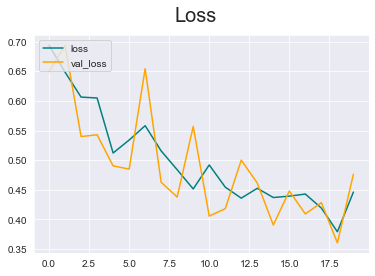

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

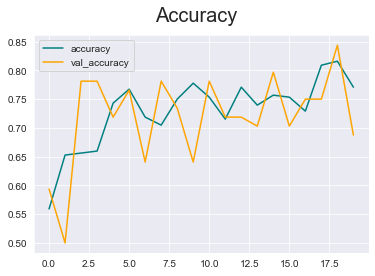

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 220ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8333333, shape=(), dtype=float32) tf.Tensor(0.88235295, shape=(), dtype=float32) tf.Tensor(0.84375, shape=(), dtype=float32)


In [36]:
predictions = model.predict(X)

1/1 [==============================] - 0s 114ms/step


In [69]:
#confusion_matrix = torch.zeros(10, 10, dtype=torch.int32)
#print(confusion_matrix.numpy())

In [71]:
cn = confusion_matrix(y_true=test, y_pred=test)

ValueError: Expected array-like (array or non-string sequence), got <TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>